<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Neural Collaborative Filtering on MovieLens dataset.

Neural Collaborative Filtering (NCF) is a well known recommendation algorithm that generalizes the matrix factorization problem with multi-layer perceptron. 

This notebook provides an example of how to utilize and evaluate NCF implementation in the `reco_utils`. We use a smaller dataset in this example to run NCF efficiently with GPU acceleration on a [Data Science Virtual Machine](https://azure.microsoft.com/en-gb/services/virtual-machines/data-science-virtual-machines/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from reco_utils.common.timer import Timer
from reco_utils.recommender.ncf.ncf_singlenode import NCF
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset
from reco_utils.dataset import movielens
from reco_utils.common.notebook_utils import is_jupyter
from reco_utils.dataset.python_splitters import python_chrono_split
from reco_utils.evaluation.python_evaluation import (precision_recall_hr_map_ndcg_at_k, rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.6.11 | packaged by conda-forge | (default, Nov 27 2020, 18:57:37) 
[GCC 9.3.0]
Pandas version: 1.1.5
Tensorflow version: 1.15.4


Set the default parameters.

In [3]:
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 50
BATCH_SIZE = 256

SEED = 42

In [4]:
from tqdm.notebook import tqdm
import os
import json
import numpy as np
import pandas as pd
from scipy.spatial import distance


BASE_PATH = '../../content/drive/MyDrive/CSE547_Final_Project/ml-100k/'

COL_NAME_PREDICTION = "prediction"
COL_NAME_USER_ID = "userId"
COL_NAME_MOVIE_ID = "movieId"
COL_NAME_ITEM_ID = COL_NAME_MOVIE_ID
COL_NAME_RATING = "rating"
COL_NAME_MOVIE_RATINGS = "movies_and_ratings"


class Utility:
    
    def __init__(self, split_type, base_path=BASE_PATH, iteration=1):
        """Init the utility class
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        splits_and_paths = self.get_splits_and_paths()
        if split_type not in splits_and_paths:
          print(f"split_type must be one of {','.join(list(splits_and_paths.keys()))}")
        valid_iterations = set(range(1,6))
        if iteration not in valid_iterations:
          print(f"iteration must be one of {','.join(list(valid_iterations))}")
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        self.base_path = base_path
        self.anonymized_data_path = os.path.join(self.base_path, splits_and_paths[split_type], f"iter_{iteration}_fix")

        self.ratings_file_name =  'ratings.csv'

        self.training_file_name = 'ratings_train.csv'
        self.test_file_name = 'ratings_test.csv'
        self.validation_file_name = 'ratings_validation.csv'
        self.evaluation_file_name = 'evaluation.csv'
        self.user_movie_ratings_matrix_file_name = 'user_movie_ratings_matrix.csv'
        self.user_to_idx_file_name =  "user_to_idx.json"
        self.movie_to_idx_file_name =  "movie_to_idx.json"

        self.k_anonymized_postfix = '_anonymized.csv'
        self.k_anonymized_map_postfix = '_anonymized_idx_to_kanon_idx.json'
    
    def get_training_user_itemlist(self):
      training_data,_,_ = self.get_unanonymized_training_data()
      return training_data.groupby(COL_NAME_USER_ID)[COL_NAME_MOVIE_ID].agg(set)
  
    def get_test_user_itemlist(self):
      test_data = self.get_test_data()
      return test_data.groupby(COL_NAME_USER_ID)[COL_NAME_MOVIE_ID].agg(set)
  

    def generate_evaluation_dataframe(self, num_negative_items_to_sample_per_user=100):
      training_data = self.get_training_user_itemlist()
      test_data = self.get_test_user_itemlist()
      users = np.unique(np.concatenate([training_data.index.values, test_data.index.values]))
      all_items_to_consider = set(self.get_movie_to_col_index().keys())
      evaluation_df = self.get_test_data()
      rows_to_add = []
      for user in users:
          items_in_train = training_data.loc[user]
          items_in_test = test_data.loc[user]
          neg_items = all_items_to_consider - items_in_train - items_in_test
          neg_items = np.random.choice(list(neg_items), size=num_negative_items_to_sample_per_user, replace=False)
          rows_to_add.extend([{COL_NAME_USER_ID:user, COL_NAME_MOVIE_ID:item, COL_NAME_RATING:0.0} for item in neg_items])
      evaluation_df = evaluation_df.append(rows_to_add, True)
      return evaluation_df
    
    def get_evaluation_path(self):
      return os.path.join(self.anonymized_data_path,self.evaluation_file_name)

    def save_evaluation_df_to(self, df, overwrite=False):
      if os.path.exists(self.get_evaluation_path()) and not(overwrite):
        print("File exists, if you want to overwrite, then pass the arugment to")
        return
      df.to_csv(self.get_evaluation_path())
    
    def get_evaluation_data(self):
        return pd.read_csv(self.get_evaluation_path())

    def get_splits_and_paths(self):
        return {
            'ratings': 'ratings_split',
            'users': 'train_test_v2/rawdata_split'
        }

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2) ** 2
    
    def manhattan_distance(self, point1, point2):
        return abs(point1 - point2).sum()
    
    def jaccard_distance(self, point1, point2):
        return distance.jaccard(point1, point2)
  
    def find_closest_point(self, points_list, point, metric='euclidean'):

        min_distance = float('inf')
        min_distance_idx = -1
        i = 0
        for p in points_list:
            if metric == 'euclidean':
                distance = self.euclidean_distance(p, point)
            elif metric == 'manhattan':
                distance = self.manhattan_distance(p, point)
            elif metric == 'jaccard':
                distance = self.jaccard_distance(p, point)
            else:
                print('Function not implemented!')

            if distance < min_distance:
                min_distance = distance
                min_distance_idx = i
            
            i += 1
        
        return min_distance_idx

    def flatten_matrix_into_dataframe(self, matrix):
        value_vars = [v for v in matrix.columns.values if v != COL_NAME_USER_ID]
        DEFAULT_VARIABLE_NAME_IN_MELT="variable"
        DEFAULT_VALUE_NAME_IN_MELT="value"
        movies_dict = self.get_col_to_movie_index()
        matrix = matrix \
        .melt(id_vars=[COL_NAME_USER_ID], value_vars=value_vars) \
        .rename(columns={DEFAULT_VARIABLE_NAME_IN_MELT: COL_NAME_MOVIE_ID, DEFAULT_VALUE_NAME_IN_MELT: COL_NAME_RATING}) \
        .apply(lambda x : pd.to_numeric(x, downcast='integer'))
        matrix[COL_NAME_MOVIE_ID] = matrix[COL_NAME_MOVIE_ID].apply(lambda x: movies_dict[x])
        matrix[COL_NAME_USER_ID] = matrix[COL_NAME_USER_ID] + 1
        matrix = matrix[matrix[COL_NAME_RATING] > 0]
        return matrix

    def get_training_data_file_path(self, k:int):
      if k ==0:
        return os.path.join(self.anonymized_data_path, "user_movie_ratings_matrix.csv")
      return os.path.join(self.anonymized_data_path, f"{k}{self.k_anonymized_postfix}")

    def get_test_data_file_path(self):
      return os.path.join(self.anonymized_data_path, self.test_file_name)

    def get_training_data(self, k:int, path=None):
      path = path if path is not None else self.get_training_data_file_path(k)
      mldf = pd.read_csv(path, header=None if k!=0 else 0).reset_index().rename(columns={'index': COL_NAME_USER_ID})
      mldf= self.flatten_matrix_into_dataframe(mldf)
      return mldf, len(mldf[COL_NAME_USER_ID].unique()), len(mldf[COL_NAME_MOVIE_ID].unique())

    def get_training_data_for_evaluation(self):
        mldf = pd.read_csv(self.get_training_data_path())
        return self._group_and_get_sets_for_evaluation(mldf)

    def get_test_data(self):
        return pd.read_csv(self.get_test_data_file_path()).apply(lambda x : pd.to_numeric(x, downcast='integer'))

    def _group_and_get_sets_for_evaluation(self, df):
        testdf=df.sort_values(by=COL_NAME_RATING, ascending=False)
        grouped=testdf.groupby(COL_NAME_USER_ID).agg({COL_NAME_MOVIE_ID:lambda x: list(x), COL_NAME_RATING:lambda x: list(x)})
        grouped[COL_NAME_MOVIE_RATINGS] = grouped.apply(lambda x: list(zip(x[COL_NAME_MOVIE_ID], x[COL_NAME_RATING])), axis=1)
        grouped=grouped.drop(columns=[COL_NAME_RATING])
        return grouped

    def get_unanonymized_training_data(self):
      df = pd.read_csv(self.get_training_data_path())
      return df.apply(pd.to_numeric), len(df[COL_NAME_USER_ID].unique()), len(df[COL_NAME_MOVIE_ID].unique())

    def get_complete_data_path(self):
      return os.path.join(self.base_path, self.ratings_file_name)

    def get_complete_data(self):
      df = pd.read_csv(self.get_complete_data_path())
      return df.apply(pd.to_numeric), len(df[COL_NAME_USER_ID].unique()), len(df[COL_NAME_MOVIE_ID].unique())
  
    def get_evaluation_data_for_evaluation(self):
      df = self.get_evaluation_data()
      return self._group_and_get_sets_for_evaluation(df)
    
    def get_test_data_for_evaluation(self):
      testdf=self.get_test_data()
      return self._group_and_get_sets_for_evaluation(testdf)
  
    def get_training_data_path(self):
        """Get path to training file
        Keyword arguments
        base_path -- The directory where files are located. 
        """        
        return os.path.join(self.anonymized_data_path, self.training_file_name)       

    def get_test_data_path(self):
        """Get path to test file
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.test_file_name)
    
    def get_validation_data_path(self):
        """Get path to validation file
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.validation_file_name)
    
    def get_train_data_user_map_path(self):
        """Get path to user id to train index file map
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.user_to_idx_file_name)
    
    def get_train_data_movie_map_path(self):
        """Get path to movie id to train index file map
        Keyword arguments
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path, self.movie_to_idx_file_name)
   
    def _coalesce_path(self,path1, path2):
        return path1 if path1 != "" else path2

    def get_utility_matrix_from_train(self):      
        # df = pd.read_csv(file_path) # Bug fix -- Check the whole dataset now and map all movies
        df, _, _ = self.get_complete_data()
        
        movie_id_to_idx_dict = self.get_movie_to_col_index()

        users = df.userId.unique()
        test_user_dict = {users[i]: i for i in range(len(users))}

        num_users = len(df.userId.unique())
        num_movies = len(movie_id_to_idx_dict) + 1
        utility_matrix = np.zeros((num_users, num_movies))

        for index, row in df.iterrows():
            movie_id, rating = int(row[COL_NAME_MOVIE_ID]), float(row[COL_NAME_RATING])
            utility_matrix[test_user_dict[row[COL_NAME_USER_ID]]][0] = int(row[COL_NAME_USER_ID])
            
            if movie_id in movie_id_to_idx_dict:
                utility_matrix[test_user_dict[row[COL_NAME_USER_ID]]][movie_id_to_idx_dict[movie_id]] = rating
            #else:
            #   print(f'Movie ID {movie_id} not found!')
        
        return utility_matrix
    
    def get_msft_ncf_dataset(self, k):
        train,_,_ = self.get_training_data(k)
        test = self.get_test_data()
        return  NCFDataset(train=train, test=test, col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID, col_rating=COL_NAME_RATING, seed=SEED), train, test
        
    def get_k_anonymized_map_path(self, k, base_path=""):
        """Get path to k-anonymzied map. 
        {k}_anonymized_idx_to_kanon_idx.json --> the mapping from user index 
        (row in the ratings_train.csv) to the row index in the 
        corresponding {k}_anonymized.csv file
        Keyword arguments
        k -- 
        base_path -- The directory where files are located. 
        """
        return os.path.join(self.anonymized_data_path,f"{k}{self.k_anonymized_map_postfix}")
    
    def get_col_to_movie_index(self):
        movie_to_idx_path = self.get_train_data_movie_map_path()
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)
        return {v:int(k) for k,v in movie_id_to_idx_dict.items()}

    def get_movie_to_col_index(self):
        movie_to_idx_path = self.get_train_data_movie_map_path()
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)
        return {int(k):v for k,v in movie_id_to_idx_dict.items()}

    def get_feature_vector_for_user(self, movie_ratings:list):
        """Returns a vector, with the same dimentions as the 
        training dataset. 
        Keyword arguments
        movie_ratings -- A list of tuples. Each tuple should be
        as follows: (movie_id, rating)
        """
        movie_to_idx_path = self.get_train_data_movie_map_path()
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)
        
        feature_vec = [0 for _ in range(len(movie_id_to_idx_dict))]
        movie_not_found= 0
        for movie_id, rating in movie_ratings:
            movie_id, rating = int(movie_id), int(rating)

            if movie_id in movie_id_to_idx_dict.keys():
                feature_vec[movie_id_to_idx_dict[movie_id]] = rating
            else:
                movie_not_found += 1
                #print(f'Movie ID {movie_id} not found!')
        print(f"{movie_not_found} movies not found.")
        return feature_vec
       
    def get_col_to_user_index(self):
        id_to_idx_path = self.get_train_data_user_map_path()
        with open(id_to_idx_path) as json_file:
            id_to_idx_dict = json.load(json_file)
        return {int(k):v for k,v in id_to_idx_dict.items()}
    
    def get_col_to_kanoncol_index(self, k):
        idx_to_kidx_path = self.get_k_anonymized_map_path(k, self.base_path)
        with open(idx_to_kidx_path) as json_file:
            idx_to_kidx_path_dict = json.load(json_file)
        return {int(k):v for k,v in idx_to_kidx_path_dict.items()}

    def get_ks(self):
        return [0, 5,8,12,15,20,25]

    def get_validation_data(self):
        return pd.read_csv(self.get_validation_data_path())

    def get_base_path(k=None):
        return self.base_path
    
    def get_closest_k_cluster_to_user_id(self, k:int, metric="euclidean"):
        id_to_idx_dict = self.get_col_to_user_index()
        idx_to_kidx_path_dict = self.get_col_to_kanoncol_index(k) if k!=0 else None
        k_anon_data_path = self.get_training_data_file_path(k)
       

        k_anaon_data = pd.read_csv(k_anon_data_path, sep=',', header=None).apply(pd.to_numeric).values

        u_matrix = self.get_utility_matrix_from_train()

        user_to_cluster_dict = {}
        for um in tqdm(u_matrix):
            user_id = int(um[0])
            row_vec = um[1:]
        
            # Easy case - We have trained on this user before
            # Just need to lookup, to see what cluster they belong to
            if user_id in id_to_idx_dict and\
            k!=0 and id_to_idx_dict[user_id] in idx_to_kidx_path_dict:            
                user_to_cluster_dict[user_id] = idx_to_kidx_path_dict[id_to_idx_dict[user_id]] + 1
            elif user_id in id_to_idx_dict and k==0: # user maps to themselves, they were in training data
                user_to_cluster_dict[user_id] = id_to_idx_dict[user_id] + 1
            else:
              #print(f'{user_id} not found in training data!')
              user_to_cluster_dict[user_id] = self.find_closest_point(k_anaon_data, row_vec, metric=metric) + 1
              #print(f'{user_id} mapped to {user_to_cluster_dict[user_id]}')
        
        return user_to_cluster_dict
      
    
def avg_mahalanobis_dist(user_movie_matrix, anon_matrix, useridx_to_cluster):
    ##user_movie_matrix and anon_matrix are numpy arrays
    #useridx_to_cluster is a dictionary mapping the index to a cluster
    d = dict()
    stdev = np.std(anon_matrix, axis = 0)
    for u, user in enumerate(user_movie_matrix):
        ##some users are not mapped to clusters
        if u in useridx_to_cluster.keys():
            cluster_idx = idx_to_cluster[u]
            cluster = anon_matrix[cluster_idx]
            d[u] = mahalanobis_dist(user, cluster, stdev)
    return np.mean(list(d.values()))

In [11]:
BASE_OUTPUT_FOLDER = "/home/fastuser/msft_ncf_output/"
MODEL_TYPE="NeuMF"

def get_recommendations_per_user(predictions, split_type, iteration, k, dist):
    util = Utility(split_type=split_type, iteration=iteration)
    user_to_cluster = util.get_closest_k_cluster_to_user_id(k, metric=dist) 
    actual_user_col = f"{COL_NAME_USER_ID}_actual"
    user_to_cluster_df = pd.DataFrame.from_dict([{COL_NAME_USER_ID:cluster, actual_user_col:user} for user,cluster in user_to_cluster.items()])
    user_to_cluster_df.set_index(COL_NAME_USER_ID, inplace=True) 
    preds = predictions.set_index(COL_NAME_USER_ID)
    preds = preds.join(user_to_cluster_df, how="inner")
    preds.reset_index(inplace=True)
    preds.drop(columns=COL_NAME_USER_ID,inplace=True)
    preds.rename(columns={actual_user_col:COL_NAME_USER_ID}, inplace=True)
    return preds

def get_base_output_folder(split_type, iteration, k, dist=None, additional_str=None):
    base = os.path.join(BASE_OUTPUT_FOLDER, split_type, f"iteration_{iteration}", str(k))
    if dist is not None:
        base = os.path.join(base, dist)
    if additional_str is not None:
        base = os.path.join(base, additional_str)
    return base

def get_output_folder_path_for_model(split_type, iteration, k, additional_str=None):
    base = get_base_output_folder(split_type,iteration,k, additional_str)
    return os.path.join(base, "model")

def does_model_exist(split_type, iteration, k, additional_str=None):
    return os.path.exists(get_output_folder_path_for_model(split_type, iteration, k, additional_str))

def save_model(ncf, split_type, iteration, k, additional_str=None):
    path = get_output_folder_path_for_model(split_type, iteration, k, additional_str)
    ncf.save(path)
    print(f"Saved to: {path}")

def load_model(ncf, split_type, iteration, k, additional_str=None):
    ncf.load(neumf_dir=get_output_folder_path_for_model(split_type, iteration, k, additional_str))
    return ncf

def get_new_model(data,
                  model_type=MODEL_TYPE,
                  n_factors=4,
                  layer_sizes=[16,8,4],
                  n_epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 lr=1e-3):
    model = NCF (
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type=model_type,
        n_factors=n_factors,
        layer_sizes=layer_sizes,
        n_epochs=n_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        verbose=10,
        seed=SEED
    )
    model.set_indices(data)
    return model

def get_dataset(split_type, iteration, k):
    return Utility(split_type=split_type, iteration=iteration).get_msft_ncf_dataset(k)

def predict(model, train):
    with Timer() as test_time:
        users, items, preds = [], [], []
        item = list(train[COL_NAME_MOVIE_ID].unique())
        for user in train[COL_NAME_USER_ID].unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={COL_NAME_USER_ID: users, COL_NAME_MOVIE_ID:items, COL_NAME_PREDICTION:preds})

    merged = pd.merge(train, all_predictions, on=[COL_NAME_USER_ID, COL_NAME_MOVIE_ID], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop(COL_NAME_RATING, axis=1)

    print("Took {} seconds for prediction.".format(test_time))
    return all_predictions

import pathlib

    
class FileSaver(object):
    def __init__(self, file_name, save_func, load_func, base_path_func=get_base_output_folder):
        self.base_path_func = base_path_func
        self.file_name = file_name
        self.save_func = save_func
        self.load_func = load_func
    
    def get_file_path(self, split_type, iteration, k, dist=None, additional_str=None):
        base = self.base_path_func(split_type,iteration,k, dist, additional_str)
        print(base)
        pathlib.Path(base).mkdir(parents=True, exist_ok=True)
        file_path = os.path.join(base, self.file_name)
        return file_path

    def save(self, item, split_type, iteration, k, dist=None, additional_str=None):
        path = self.get_file_path(split_type, iteration, k, dist, additional_str)
        self.save_func(item, path)
        print(f"Saved item to {path}")
    
    def load(self, split_type, iteration, k, item=None , dist=None, additional_str=None):
        return self.load_func(item, self.get_file_path(split_type, iteration, k, dist, additional_str))
    
    def does_exist(self, split_type, iteration, k, dist=None, additional_str=None):
        return os.path.exists(self.get_file_path(split_type, iteration, k, dist, additional_str))

def evaluate_from_cluster(cluster_predictions, split_type, iteration, k, dist_type, top_k=TOP_K, data_eval='test'):
    user_preds = get_recommendations_per_user(cluster_predictions, split_type, iteration,k, dist_type)
    return evaluate(user_preds, split_type, iteration, top_k=top_k, data_eval=data_eval)
    
def evaluate(predictions, split_type, iteration, top_k=TOP_K, data_eval='test'):
    test = None
    util = Utility(split_type=split_type, iteration=iteration)
    if data_eval == 'test':
        test = util.get_test_data()
    elif data_eval == 'validation':
        test = util.get_validation_data()
    else:
        raise Exception('Invalid data_eval type')
    eval_precision, eval_recall, eval_hr, eval_map, eval_ndcg = precision_recall_hr_map_ndcg_at_k(test, predictions, col_prediction='prediction', col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID, k=top_k)
    
    print("MAP:\t%f" % eval_map,
          "NDCG:\t%f" % eval_ndcg,
          "Precision@K:\t%f" % eval_precision,
          "Recall@K:\t%f" % eval_recall,
          "HR@K:\t%f" % eval_hr, sep='\n') 
    return eval_map, eval_ndcg, eval_precision, eval_recall, eval_hr
    
def get_df_filesaver(file_name):
    return FileSaver(
    file_name,\
    save_func=lambda i,f: i.to_csv(f),\
    load_func=lambda i,f: pd.read_csv(f, index_col=0))


ClusterPredictionSaver = get_df_filesaver('cluster_level_predictions.csv')
RatingsParamsSaver = get_df_filesaver('ratings_params.csv')
UsersParamsSaver = get_df_filesaver('users_params.csv')





In [12]:

results = pd.DataFrame(columns=['iteration', 'k', 'split_type', 'distance_metric', 'map@10', 'ndcg@10', 'precision@10', 'recall@10', 'hr@10'])
iterations = range(1,6)
ks = Utility('ratings').get_ks()
split_types=['ratings', 'users']
dist_metrics= ['euclidean', 'jaccard']
res_list = []
OUT_FILE='evaluation_resultsv2.csv'
RERUN=True
if os.path.exists(OUT_FILE):
    results = pd.read_csv(OUT_FILE)

def is_entry_in_evaluation_df(df, split_type, iteration, k, dist_metric):
    return len(df[(df['split_type'] == split_type) & (df['iteration']==iteration) & (df['k']==k) & (df['distance_metric']==dist_metric)]) > 0

for iteration in iterations:
    for k in ks:
        for split_type in split_types:
            predictions = ClusterPredictionSaver.load(split_type, iteration, k)
            for dist_metric in dist_metrics:
                #split_type = 'ratings'
                #iteration = 3
                #k = 15
                if (not RERUN) and is_entry_in_evaluation_df(results, split_type, iteration, k, dist_metric):
                    print(f"Already have evaluation for ({split_type}, {iteration}, {k}, {dist_metric}")
                    display(df[(df['split_type'] == split_type) & (df['iteration']==iteration) & (df['k']==k) & (df['distance_metric']==dist_metric)])
                    continue
                try:
                    meanap, ndcg, precision, recall, hr = evaluate_from_cluster(predictions, split_type,  iteration, k, dist_metric)
                    result = {'iteration':iteration ,\
                              'k':k,\
                              'split_type':split_type,\
                              'distance_metric':dist_metric,\
                              'map@10':meanap,\
                              'ndcg@10':ndcg,\
                              'precision@10':precision,\
                              'recall@10':recall,\
                             'hr@10':hr}
                    results = results.append([result])
                    results.to_csv(OUT_FILE, index=False)
                except:
                    print(f"Likely is not done yet: {split_type} | {iteration} | {k}")
                    raise


/home/fastuser/msft_ncf_output/ratings/iteration_1/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.042618
NDCG:	0.129711
Precision@K:	0.099337
Recall@K:	0.097293
HR@K:	0.533997


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.042618
NDCG:	0.129711
Precision@K:	0.099337
Recall@K:	0.097293
HR@K:	0.533997
/home/fastuser/msft_ncf_output/users/iteration_1/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.022280
NDCG:	0.263104
Precision@K:	0.244262
Recall@K:	0.042689
HR@K:	0.786885


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.019024
NDCG:	0.182734
Precision@K:	0.168852
Recall@K:	0.034852
HR@K:	0.672131
/home/fastuser/msft_ncf_output/ratings/iteration_1/5


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012860
NDCG:	0.059119
Precision@K:	0.049420
Recall@K:	0.032367
HR@K:	0.308458


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012860
NDCG:	0.059119
Precision@K:	0.049420
Recall@K:	0.032367
HR@K:	0.308458
/home/fastuser/msft_ncf_output/users/iteration_1/5


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000806
NDCG:	0.024254
Precision@K:	0.026230
Recall@K:	0.003181
HR@K:	0.196721


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012566
NDCG:	0.171310
Precision@K:	0.154098
Recall@K:	0.022406
HR@K:	0.573770
/home/fastuser/msft_ncf_output/ratings/iteration_1/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009052
NDCG:	0.040806
Precision@K:	0.032504
Recall@K:	0.020813
HR@K:	0.210614


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009052
NDCG:	0.040806
Precision@K:	0.032504
Recall@K:	0.020813
HR@K:	0.210614
/home/fastuser/msft_ncf_output/users/iteration_1/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009710
NDCG:	0.155482
Precision@K:	0.145902
Recall@K:	0.021396
HR@K:	0.672131


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.011016
NDCG:	0.140288
Precision@K:	0.132787
Recall@K:	0.024293
HR@K:	0.655738
/home/fastuser/msft_ncf_output/ratings/iteration_1/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005524
NDCG:	0.023435
Precision@K:	0.020564
Recall@K:	0.013326
HR@K:	0.152570


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005486
NDCG:	0.022734
Precision@K:	0.019569
Recall@K:	0.013030
HR@K:	0.142620
/home/fastuser/msft_ncf_output/users/iteration_1/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004322
NDCG:	0.087259
Precision@K:	0.077049
Recall@K:	0.009974
HR@K:	0.360656


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005035
NDCG:	0.104332
Precision@K:	0.098361
Recall@K:	0.012965
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_1/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002883
NDCG:	0.017377
Precision@K:	0.015423
Recall@K:	0.007561
HR@K:	0.119403


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002816
NDCG:	0.016981
Precision@K:	0.015257
Recall@K:	0.007521
HR@K:	0.117745
/home/fastuser/msft_ncf_output/users/iteration_1/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002920
NDCG:	0.056049
Precision@K:	0.050820
Recall@K:	0.006140
HR@K:	0.327869


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005365
NDCG:	0.085110
Precision@K:	0.077049
Recall@K:	0.011363
HR@K:	0.475410
/home/fastuser/msft_ncf_output/ratings/iteration_1/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002422
NDCG:	0.011066
Precision@K:	0.009287
Recall@K:	0.007000
HR@K:	0.072968


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002392
NDCG:	0.010806
Precision@K:	0.009287
Recall@K:	0.007013
HR@K:	0.072968
/home/fastuser/msft_ncf_output/users/iteration_1/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000185
NDCG:	0.010225
Precision@K:	0.009836
Recall@K:	0.000644
HR@K:	0.081967


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004266
NDCG:	0.066572
Precision@K:	0.063934
Recall@K:	0.008898
HR@K:	0.360656
/home/fastuser/msft_ncf_output/ratings/iteration_1/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004008
NDCG:	0.012933
Precision@K:	0.008955
Recall@K:	0.006904
HR@K:	0.074627


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003986
NDCG:	0.012710
Precision@K:	0.008789
Recall@K:	0.006871
HR@K:	0.072968
/home/fastuser/msft_ncf_output/users/iteration_1/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.001347
NDCG:	0.027280
Precision@K:	0.024590
Recall@K:	0.002740
HR@K:	0.229508


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002199
NDCG:	0.057684
Precision@K:	0.060656
Recall@K:	0.006825
HR@K:	0.393443
/home/fastuser/msft_ncf_output/ratings/iteration_2/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.045398
NDCG:	0.133388
Precision@K:	0.101163
Recall@K:	0.100637
HR@K:	0.521595


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.045398
NDCG:	0.133388
Precision@K:	0.101163
Recall@K:	0.100637
HR@K:	0.521595
/home/fastuser/msft_ncf_output/users/iteration_2/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.021304
NDCG:	0.306783
Precision@K:	0.288525
Recall@K:	0.035202
HR@K:	0.754098


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.019515
NDCG:	0.291034
Precision@K:	0.277049
Recall@K:	0.032622
HR@K:	0.704918
/home/fastuser/msft_ncf_output/ratings/iteration_2/5


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.015225
NDCG:	0.058489
Precision@K:	0.045847
Recall@K:	0.033942
HR@K:	0.300664


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.015225
NDCG:	0.058489
Precision@K:	0.045847
Recall@K:	0.033942
HR@K:	0.300664
/home/fastuser/msft_ncf_output/users/iteration_2/5


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005290
NDCG:	0.129749
Precision@K:	0.124590
Recall@K:	0.014564
HR@K:	0.590164


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008620
NDCG:	0.194954
Precision@K:	0.190164
Recall@K:	0.020576
HR@K:	0.721311
/home/fastuser/msft_ncf_output/ratings/iteration_2/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.011201
NDCG:	0.042726
Precision@K:	0.033721
Recall@K:	0.027839
HR@K:	0.225914


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.011201
NDCG:	0.042726
Precision@K:	0.033721
Recall@K:	0.027839
HR@K:	0.225914
/home/fastuser/msft_ncf_output/users/iteration_2/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003217
NDCG:	0.088168
Precision@K:	0.103279
Recall@K:	0.010713
HR@K:	0.491803


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004222
NDCG:	0.146950
Precision@K:	0.144262
Recall@K:	0.011223
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_2/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008350
NDCG:	0.030322
Precision@K:	0.022924
Recall@K:	0.021062
HR@K:	0.161130


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008400
NDCG:	0.030699
Precision@K:	0.023256
Recall@K:	0.021186
HR@K:	0.164452
/home/fastuser/msft_ncf_output/users/iteration_2/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006055
NDCG:	0.176299
Precision@K:	0.175410
Recall@K:	0.013672
HR@K:	0.590164


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006934
NDCG:	0.153552
Precision@K:	0.134426
Recall@K:	0.012925
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_2/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003555
NDCG:	0.019728
Precision@K:	0.017110
Recall@K:	0.009471
HR@K:	0.124585


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003483
NDCG:	0.019175
Precision@K:	0.016777
Recall@K:	0.009422
HR@K:	0.126246
/home/fastuser/msft_ncf_output/users/iteration_2/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003743
NDCG:	0.100822
Precision@K:	0.104918
Recall@K:	0.010712
HR@K:	0.540984


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009008
NDCG:	0.149703
Precision@K:	0.136066
Recall@K:	0.016326
HR@K:	0.573770
/home/fastuser/msft_ncf_output/ratings/iteration_2/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003209
NDCG:	0.014501
Precision@K:	0.012791
Recall@K:	0.007657
HR@K:	0.109635


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003236
NDCG:	0.014464
Precision@K:	0.012458
Recall@K:	0.007580
HR@K:	0.107973
/home/fastuser/msft_ncf_output/users/iteration_2/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.007139
NDCG:	0.125711
Precision@K:	0.098361
Recall@K:	0.010835
HR@K:	0.540984


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003562
NDCG:	0.106438
Precision@K:	0.113115
Recall@K:	0.009579
HR@K:	0.409836
/home/fastuser/msft_ncf_output/ratings/iteration_2/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000868
NDCG:	0.007843
Precision@K:	0.007475
Recall@K:	0.002654
HR@K:	0.059801


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000869
NDCG:	0.007823
Precision@K:	0.007475
Recall@K:	0.002678
HR@K:	0.059801
/home/fastuser/msft_ncf_output/users/iteration_2/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004640
NDCG:	0.144180
Precision@K:	0.124590
Recall@K:	0.008994
HR@K:	0.393443


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005378
NDCG:	0.117326
Precision@K:	0.103279
Recall@K:	0.009976
HR@K:	0.491803
/home/fastuser/msft_ncf_output/ratings/iteration_3/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.042738
NDCG:	0.131065
Precision@K:	0.099833
Recall@K:	0.102152
HR@K:	0.525000


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.042738
NDCG:	0.131065
Precision@K:	0.099833
Recall@K:	0.102152
HR@K:	0.525000
/home/fastuser/msft_ncf_output/users/iteration_3/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.023259
NDCG:	0.288398
Precision@K:	0.273770
Recall@K:	0.041984
HR@K:	0.786885


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.018578
NDCG:	0.209277
Precision@K:	0.201639
Recall@K:	0.035171
HR@K:	0.737705
/home/fastuser/msft_ncf_output/ratings/iteration_3/5


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012024
NDCG:	0.053806
Precision@K:	0.043000
Recall@K:	0.029141
HR@K:	0.285000


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012024
NDCG:	0.053806
Precision@K:	0.043000
Recall@K:	0.029141
HR@K:	0.285000
/home/fastuser/msft_ncf_output/users/iteration_3/5


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002844
NDCG:	0.087456
Precision@K:	0.075410
Recall@K:	0.005484
HR@K:	0.344262


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009454
NDCG:	0.148870
Precision@K:	0.137705
Recall@K:	0.017115
HR@K:	0.573770
/home/fastuser/msft_ncf_output/ratings/iteration_3/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008363
NDCG:	0.037463
Precision@K:	0.031333
Recall@K:	0.023205
HR@K:	0.213333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008363
NDCG:	0.037463
Precision@K:	0.031333
Recall@K:	0.023205
HR@K:	0.213333
/home/fastuser/msft_ncf_output/users/iteration_3/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012903
NDCG:	0.181293
Precision@K:	0.163934
Recall@K:	0.024807
HR@K:	0.704918


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008243
NDCG:	0.150331
Precision@K:	0.147541
Recall@K:	0.019647
HR@K:	0.672131
/home/fastuser/msft_ncf_output/ratings/iteration_3/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004492
NDCG:	0.020542
Precision@K:	0.017833
Recall@K:	0.011540
HR@K:	0.133333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004403
NDCG:	0.019554
Precision@K:	0.016833
Recall@K:	0.011256
HR@K:	0.123333
/home/fastuser/msft_ncf_output/users/iteration_3/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006735
NDCG:	0.134636
Precision@K:	0.124590
Recall@K:	0.013708
HR@K:	0.540984


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005463
NDCG:	0.115203
Precision@K:	0.114754
Recall@K:	0.014112
HR@K:	0.508197
/home/fastuser/msft_ncf_output/ratings/iteration_3/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003671
NDCG:	0.019713
Precision@K:	0.017167
Recall@K:	0.010485
HR@K:	0.136667


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003639
NDCG:	0.019590
Precision@K:	0.017333
Recall@K:	0.010564
HR@K:	0.136667
/home/fastuser/msft_ncf_output/users/iteration_3/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005060
NDCG:	0.098010
Precision@K:	0.100000
Recall@K:	0.012013
HR@K:	0.459016


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.007361
NDCG:	0.135402
Precision@K:	0.122951
Recall@K:	0.016122
HR@K:	0.557377
/home/fastuser/msft_ncf_output/ratings/iteration_3/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002920
NDCG:	0.015049
Precision@K:	0.013167
Recall@K:	0.009328
HR@K:	0.103333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002941
NDCG:	0.015470
Precision@K:	0.013667
Recall@K:	0.009441
HR@K:	0.108333
/home/fastuser/msft_ncf_output/users/iteration_3/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006044
NDCG:	0.104154
Precision@K:	0.080328
Recall@K:	0.010664
HR@K:	0.475410


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003321
NDCG:	0.087441
Precision@K:	0.078689
Recall@K:	0.009675
HR@K:	0.442623
/home/fastuser/msft_ncf_output/ratings/iteration_3/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.001348
NDCG:	0.010299
Precision@K:	0.008667
Recall@K:	0.004099
HR@K:	0.068333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.001273
NDCG:	0.009932
Precision@K:	0.008500
Recall@K:	0.004024
HR@K:	0.066667
/home/fastuser/msft_ncf_output/users/iteration_3/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004284
NDCG:	0.122852
Precision@K:	0.121311
Recall@K:	0.011579
HR@K:	0.573770


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002458
NDCG:	0.091744
Precision@K:	0.096721
Recall@K:	0.006950
HR@K:	0.409836
/home/fastuser/msft_ncf_output/ratings/iteration_4/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.044501
NDCG:	0.132365
Precision@K:	0.098993
Recall@K:	0.107670
HR@K:	0.525168


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.044501
NDCG:	0.132365
Precision@K:	0.098993
Recall@K:	0.107670
HR@K:	0.525168
/home/fastuser/msft_ncf_output/users/iteration_4/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.019925
NDCG:	0.264717
Precision@K:	0.240984
Recall@K:	0.038361
HR@K:	0.819672


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.018712
NDCG:	0.229516
Precision@K:	0.208197
Recall@K:	0.036630
HR@K:	0.704918
/home/fastuser/msft_ncf_output/ratings/iteration_4/5


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.017121
NDCG:	0.066183
Precision@K:	0.051007
Recall@K:	0.045732
HR@K:	0.315436


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.017121
NDCG:	0.066183
Precision@K:	0.051007
Recall@K:	0.045732
HR@K:	0.315436
/home/fastuser/msft_ncf_output/users/iteration_4/5


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009096
NDCG:	0.138055
Precision@K:	0.124590
Recall@K:	0.016429
HR@K:	0.540984


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012011
NDCG:	0.149945
Precision@K:	0.134426
Recall@K:	0.023779
HR@K:	0.655738
/home/fastuser/msft_ncf_output/ratings/iteration_4/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008080
NDCG:	0.034280
Precision@K:	0.027013
Recall@K:	0.016761
HR@K:	0.184564


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008080
NDCG:	0.034280
Precision@K:	0.027013
Recall@K:	0.016761
HR@K:	0.184564
/home/fastuser/msft_ncf_output/users/iteration_4/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.013808
NDCG:	0.209244
Precision@K:	0.196721
Recall@K:	0.026944
HR@K:	0.655738


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.010016
NDCG:	0.170429
Precision@K:	0.160656
Recall@K:	0.019664
HR@K:	0.606557
/home/fastuser/msft_ncf_output/ratings/iteration_4/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005502
NDCG:	0.025672
Precision@K:	0.020805
Recall@K:	0.014094
HR@K:	0.157718


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005486
NDCG:	0.025647
Precision@K:	0.020805
Recall@K:	0.014054
HR@K:	0.157718
/home/fastuser/msft_ncf_output/users/iteration_4/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.007822
NDCG:	0.137320
Precision@K:	0.132787
Recall@K:	0.016015
HR@K:	0.491803


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.008088
NDCG:	0.131558
Precision@K:	0.116393
Recall@K:	0.014226
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_4/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005881
NDCG:	0.023818
Precision@K:	0.018456
Recall@K:	0.011832
HR@K:	0.134228


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005894
NDCG:	0.023952
Precision@K:	0.018624
Recall@K:	0.011905
HR@K:	0.135906
/home/fastuser/msft_ncf_output/users/iteration_4/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002112
NDCG:	0.081930
Precision@K:	0.085246
Recall@K:	0.008382
HR@K:	0.459016


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.007207
NDCG:	0.120656
Precision@K:	0.103279
Recall@K:	0.014276
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_4/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002524
NDCG:	0.010675
Precision@K:	0.008725
Recall@K:	0.007393
HR@K:	0.082215


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002506
NDCG:	0.010577
Precision@K:	0.008893
Recall@K:	0.007435
HR@K:	0.082215
/home/fastuser/msft_ncf_output/users/iteration_4/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002840
NDCG:	0.084437
Precision@K:	0.093443
Recall@K:	0.010084
HR@K:	0.459016


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002067
NDCG:	0.053552
Precision@K:	0.060656
Recall@K:	0.008444
HR@K:	0.360656
/home/fastuser/msft_ncf_output/ratings/iteration_4/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.001895
NDCG:	0.010091
Precision@K:	0.009228
Recall@K:	0.005684
HR@K:	0.077181


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.001900
NDCG:	0.010086
Precision@K:	0.009060
Recall@K:	0.005608
HR@K:	0.075503
/home/fastuser/msft_ncf_output/users/iteration_4/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000175
NDCG:	0.015031
Precision@K:	0.016393
Recall@K:	0.000682
HR@K:	0.131148


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005332
NDCG:	0.090929
Precision@K:	0.080328
Recall@K:	0.010508
HR@K:	0.442623
/home/fastuser/msft_ncf_output/ratings/iteration_5/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.052346
NDCG:	0.148370
Precision@K:	0.109000
Recall@K:	0.120858
HR@K:	0.570000


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.052346
NDCG:	0.148370
Precision@K:	0.109000
Recall@K:	0.120858
HR@K:	0.570000
/home/fastuser/msft_ncf_output/users/iteration_5/0


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.010484
NDCG:	0.165324
Precision@K:	0.150820
Recall@K:	0.020590
HR@K:	0.606557


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.015956
NDCG:	0.235773
Precision@K:	0.213559
Recall@K:	0.026889
HR@K:	0.644068
/home/fastuser/msft_ncf_output/ratings/iteration_5/5


/home/fastuser/miniconda3/envs/reco_gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012800
NDCG:	0.056556
Precision@K:	0.044500
Recall@K:	0.034152
HR@K:	0.288333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.012800
NDCG:	0.056556
Precision@K:	0.044500
Recall@K:	0.034152
HR@K:	0.288333
/home/fastuser/msft_ncf_output/users/iteration_5/5


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.014067
NDCG:	0.188054
Precision@K:	0.152459
Recall@K:	0.022034
HR@K:	0.622951


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006929
NDCG:	0.147825
Precision@K:	0.139344
Recall@K:	0.015508
HR@K:	0.540984
/home/fastuser/msft_ncf_output/ratings/iteration_5/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.010670
NDCG:	0.044591
Precision@K:	0.034667
Recall@K:	0.025341
HR@K:	0.243333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.010658
NDCG:	0.044433
Precision@K:	0.034500
Recall@K:	0.025292
HR@K:	0.241667
/home/fastuser/msft_ncf_output/users/iteration_5/8


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000998
NDCG:	0.042780
Precision@K:	0.034426
Recall@K:	0.002577
HR@K:	0.229508


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005710
NDCG:	0.141488
Precision@K:	0.132787
Recall@K:	0.012720
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_5/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005500
NDCG:	0.023753
Precision@K:	0.020167
Recall@K:	0.013452
HR@K:	0.158333


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005515
NDCG:	0.023790
Precision@K:	0.020000
Recall@K:	0.013377
HR@K:	0.156667
/home/fastuser/msft_ncf_output/users/iteration_5/12


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.010317
NDCG:	0.169537
Precision@K:	0.147541
Recall@K:	0.018179
HR@K:	0.606557


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.009196
NDCG:	0.139742
Precision@K:	0.122951
Recall@K:	0.015511
HR@K:	0.540984
/home/fastuser/msft_ncf_output/ratings/iteration_5/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004262
NDCG:	0.019246
Precision@K:	0.015167
Recall@K:	0.011663
HR@K:	0.126667


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004274
NDCG:	0.019490
Precision@K:	0.015500
Recall@K:	0.011752
HR@K:	0.130000
/home/fastuser/msft_ncf_output/users/iteration_5/15


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006393
NDCG:	0.109167
Precision@K:	0.090164
Recall@K:	0.011627
HR@K:	0.426230


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.006329
NDCG:	0.121071
Precision@K:	0.113115
Recall@K:	0.013543
HR@K:	0.524590
/home/fastuser/msft_ncf_output/ratings/iteration_5/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003608
NDCG:	0.015609
Precision@K:	0.013500
Recall@K:	0.008642
HR@K:	0.110000


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003590
NDCG:	0.015221
Precision@K:	0.013000
Recall@K:	0.008539
HR@K:	0.105000
/home/fastuser/msft_ncf_output/users/iteration_5/20


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.004276
NDCG:	0.083623
Precision@K:	0.073770
Recall@K:	0.008944
HR@K:	0.409836


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.005404
NDCG:	0.090230
Precision@K:	0.085246
Recall@K:	0.010666
HR@K:	0.409836
/home/fastuser/msft_ncf_output/ratings/iteration_5/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002506
NDCG:	0.012167
Precision@K:	0.009833
Recall@K:	0.006467
HR@K:	0.081667


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.002502
NDCG:	0.012246
Precision@K:	0.010167
Recall@K:	0.006542
HR@K:	0.083333
/home/fastuser/msft_ncf_output/users/iteration_5/25


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.000423
NDCG:	0.021583
Precision@K:	0.027869
Recall@K:	0.002404
HR@K:	0.262295


  0%|          | 0/610 [00:00<?, ?it/s]

MAP:	0.003115
NDCG:	0.093430
Precision@K:	0.090164
Recall@K:	0.009645
HR@K:	0.459016


In [13]:
results.to_csv('evaluation_resultsv2.csv', index=False)

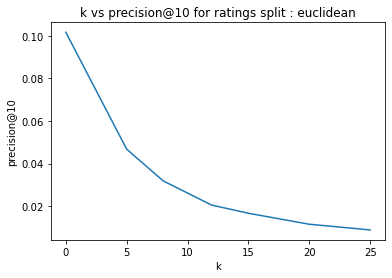

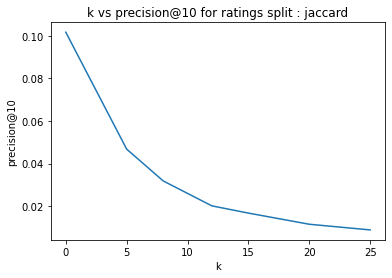

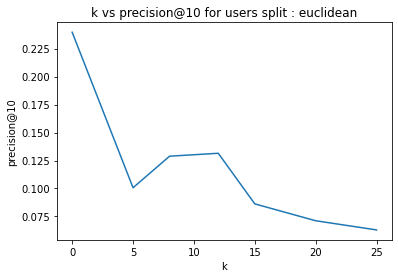

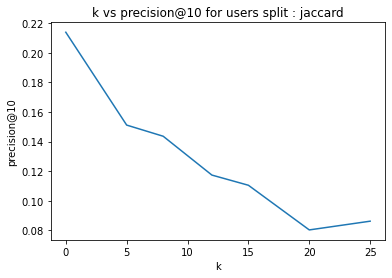

In [50]:
groupped = results.groupby(['split_type', 'distance_metric', 'k']).agg('mean').reset_index()
import matplotlib.pyplot as plt

def plot_metric_vs_k(df, dist_metric, split_type, metric):
    base = df.loc[(df['distance_metric'] == dist_metric) &( df['split_type'] == split_type) ]
    ks = base.k.values
    metrics = base[metric].values
    plt.plot(ks, metrics)
    plt.xlabel('k')
    plt.ylabel(metric)
    plt.title(f'k vs {metric} for {split_type} split : {dist_metric}')
    plt.show()

for split_type in split_types:
    for dist_type in ['euclidean', 'jaccard']:
        plot_metric_vs_k(groupped, dist_type, split_type, 'precision@10')

In [ ]:
#train, test = python_chrono_split(df, 0.75)
train = Utility('ratings', iteration=1).get_training_data(0)[0]
test=Utility('ratings', iteration=1).get_test_data()
test.head(5)

In [ ]:
train.head(5)

Generate an NCF dataset object from the data subsets.

In [ ]:
data = NCFDataset(train=train, test=test, col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID, col_rating=COL_NAME_RATING, seed=SEED)

### 3. Train the NCF model on the training data, and get the top-k recommendations for our testing data

NCF accepts implicit feedback and generates prospensity of items to be recommended to users in the scale of 0 to 1. A recommended item list can then be generated based on the scores. Note that this quickstart notebook is using a smaller number of epochs to reduce time for training. As a consequence, the model performance will be slighlty deteriorated. 

In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

In the movie recommendation use case scenario, seen movies are not recommended to the users.

In [ ]:
import importlib
importlib.

In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train[COL_NAME_MOVIE_ID].unique())
    for user in train[COL_NAME_USER_ID].unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={COL_NAME_USER_ID: users, COL_NAME_MOVIE_ID:items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=[COL_NAME_USER_ID, COL_NAME_MOVIE_ID], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop(COL_NAME_RATING, axis=1)

print("Took {} seconds for prediction.".format(test_time))

### 4. Evaluate how well NCF performs

The ranking metrics are used for evaluation.

In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID,k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction',col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID, k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID, k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', col_user=COL_NAME_USER_ID, col_item=COL_NAME_MOVIE_ID, k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

In [ ]:
if is_jupyter():
    # Record results with papermill for tests
    import papermill as pm
    import scrapbook as sb
    sb.glue("map", eval_map)
    sb.glue("ndcg", eval_ndcg)
    sb.glue("precision", eval_precision)
    sb.glue("recall", eval_recall)
    sb.glue("train_time", train_time.interval)
    sb.glue("test_time", test_time.interval)